This is an experimental (stub...) Schema.org dashboard using Jupyter/iPython

See corresponding Github [issue #896](https://github.com/schemaorg/schemaorg/issues/896). 

In [69]:
# Import libraries

import unittest
import os
import pprint
from os import path, getenv
from os.path import expanduser
import logging # https://docs.python.org/2/library/logging.html#logging-levels
import glob
import argparse
import StringIO
import sys

# 3rd party, see e.g. http://pbpython.com/simple-graphing-pandas.html

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.__version__
%matplotlib inline

# Locally,

print os.getcwd()
if os.getcwd().endswith('schemaorg'):
    print "Working from: ", os.getcwd()
else:
    #print "cd .."
    os.chdir("..")

# We'll need our lib/ dir, plus AppEngine's files:
sys.path.append( os.getcwd() ) 
sdk_path = getenv('APP_ENGINE',  expanduser("~") + '/google-cloud-sdk/platform/google_appengine/')
sys.path.insert(0, sdk_path) 
print "GAE: ", sdk_path

# previous useful:
import dev_appserver
dev_appserver.fix_sys_path()
# pprint.pprint(os.environ.copy())

/Users/danbri/sdo/official/schemaorg
Working from:  /Users/danbri/sdo/official/schemaorg
GAE:  /Users/danbri/google-cloud-sdk/platform/google_appengine/


In [70]:
import rdflib
from rdflib import Graph
from rdflib import RDF, RDFS
from rdflib.term import URIRef, Literal
from rdflib.parser import Parser
from rdflib.serializer import Serializer
from rdflib.plugins.sparql import prepareQuery
from rdflib.compare import graph_diff
import threading
from api import inLayer,read_file, full_path, read_schemas, read_extensions, read_examples, namespaces, DataCache, getMasterStore
from api import  setInTestHarness, GetAllTypes, Unit, GetImmediateSubtypes # old API
from apirdflib import getNss



In [71]:
# Setup
setInTestHarness(True)
import sdoapp

rdflib.plugin.register("json-ld", Serializer, "rdflib_jsonld.serializer", "JsonLDSerializer")

store = getMasterStore()
read_schemas(loadExtensions=True)
read_extensions(sdoapp.ENABLED_EXTENSIONS)
graphs = list(store.graphs())

In [72]:
# Utilities

def findGraph(guri):
    myg = ""
    for g in graphs:
      #print g.identifier
      if str(g.identifier) == guri:
          myg = g
          # print "Found graph %s for graph URI %s" % (g, guri)
    # print myg
    if myg == "":
        print "Didn't find graph %s." % guri
        return None
    else:
        return myg

# Convert SPARQL results to Pandas DataFrame:
from pandas import DataFrame

def sparql2df(a, cast_to_numeric=True):
    c = []
    for b in a.bindings:
        rowvals=[]
        for k in a.vars:
            rowvals.append(b[k])
        c.append(rowvals)

    df = DataFrame(c)
    df.columns = [str(v) for v in a.vars]
    if cast_to_numeric:
      df = df.apply(lambda x: pd.to_numeric(x, errors='ignore'))

    return df

# Overview

We have two APIs, the original pseudo-RDF unit/node structure, plus also now RDFLib. 
It is better to use the latter as it gives access to SPARQL, parsers/serializers etc.

In [73]:
sdocore = findGraph("http://schema.org/")
bibex = findGraph("http://bib.schema.org/")
auto = findGraph("http://auto.schema.org/")


In [74]:
# Test OLD API (skip this, unless debugging; slow on first run.)

pprint.pprint( "Found %s types." % len( GetAllTypes() ) )
for t in ["Article", "CreativeWork", "Product", "MedicalEntity", "Event"]: 
    someType = Unit.GetUnit(t)
    p_subtypes = GetImmediateSubtypes(someType)
    pprint.pprint( "Direct subtypes of %s: %s" % ( someType.id, ', '.join([str(x.id) for x in p_subtypes]) ) )
 

'Found 583 types.'
u'Direct subtypes of Article: NewsArticle, Report, ScholarlyArticle, SocialMediaPosting, TechArticle'
u'Direct subtypes of CreativeWork: Article, Blog, Book, Clip, Code, Comment, Conversation, CreativeWorkSeason, CreativeWorkSeries, DataCatalog, Dataset, DigitalDocument, Episode, Game, Map, MediaObject, Message, Movie, MusicComposition, MusicPlaylist, MusicRecording, Painting, Photograph, PublicationIssue, PublicationVolume, Question, Recipe, Review, Sculpture, Season, Series, SoftwareApplication, SoftwareSourceCode, TVSeason, TVSeries, VisualArtwork, WebPage, WebPageElement, WebSite'
u'Direct subtypes of Product: IndividualProduct, ProductModel, SomeProducts, Vehicle'
u'Direct subtypes of MedicalEntity: '
u'Direct subtypes of Event: BusinessEvent, ChildrensEvent, ComedyEvent, DanceEvent, DeliveryEvent, EducationEvent, ExhibitionEvent, Festival, FoodEvent, LiteraryEvent, MusicEvent, PublicationEvent, SaleEvent, ScreeningEvent, SocialEvent, SportsEvent, TheaterEvent, 

In [75]:
renamed =  sdocore.query("select ?x ?y where { ?x <http://schema.org/supersededBy> ?y }")

for (old, new) in renamed:
    print "older: %s -> newer: %s" % (old, new)

older: http://schema.org/merchant -> newer: http://schema.org/seller
older: http://schema.org/attendees -> newer: http://schema.org/attendee
older: http://schema.org/catalog -> newer: http://schema.org/includedInDataCatalog
older: http://schema.org/area -> newer: http://schema.org/serviceArea
older: http://schema.org/containedIn -> newer: http://schema.org/containedInPlace
older: http://schema.org/sampleType -> newer: http://schema.org/codeSampleType
older: http://schema.org/collection -> newer: http://schema.org/targetCollection
older: http://schema.org/warrantyPromise -> newer: http://schema.org/warranty
older: http://schema.org/Taxi -> newer: http://schema.org/TaxiService
older: http://schema.org/application -> newer: http://schema.org/actionApplication
older: http://schema.org/Code -> newer: http://schema.org/SoftwareSourceCode
older: http://schema.org/UserPageVisits -> newer: http://schema.org/InteractionCounter
older: http://schema.org/DatedMoneySpecification -> newer: http://sch

In [7]:
a = bibex.query("select ?x ?p ?y where { ?x ?p ?y } LIMIT 3")
sparql2df(a)

,x,p,y
0,http://schema.org/Chapter,http://www.w3.org/2000/01/rdf-schema#label,Chapter
1,http://schema.org/Newspaper,http://www.w3.org/2000/01/rdf-schema#label,Newspaper
2,http://schema.org/Collection,http://www.w3.org/2000/01/rdf-schema#subClassOf,http://schema.org/CreativeWork


In [8]:
sparql2df( sdocore.query("select ?item ?type where { ?item a ?type }") )

,item,type
0,http://schema.org/associatedArticle,http://www.w3.org/1999/02/22-rdf-syntax-ns#Pro...
1,http://schema.org/awayTeam,http://www.w3.org/1999/02/22-rdf-syntax-ns#Pro...
2,http://schema.org/lastReviewed,http://www.w3.org/1999/02/22-rdf-syntax-ns#Pro...
3,http://schema.org/VideoGallery,http://www.w3.org/2000/01/rdf-schema#Class
4,http://schema.org/orderDate,http://www.w3.org/1999/02/22-rdf-syntax-ns#Pro...
5,http://schema.org/Church,http://www.w3.org/2000/01/rdf-schema#Class
6,http://schema.org/AssignAction,http://www.w3.org/2000/01/rdf-schema#Class
7,http://schema.org/pagination,http://www.w3.org/1999/02/22-rdf-syntax-ns#Pro...
8,http://schema.org/Rating,http://www.w3.org/2000/01/rdf-schema#Class
9,http://schema.org/supportingData,http://www.w3.org/1999/02/22-rdf-syntax-ns#Pro...


In [9]:
s="""SELECT ?child (count(?grandchild) as ?nGrandchildren) where {
  ?child rdfs:subClassOf schema:Thing .
  OPTIONAL { ?grandchild rdfs:subClassOf ?child }
}
GROUP BY ?child order by desc(count(?grandchild))"""
ets = sparql2df(  sdocore.query(s)) # Count subtypes

                            child  nGrandchildren
0  http://schema.org/CreativeWork              39
1    http://schema.org/Intangible              36
2         http://schema.org/Event              19
3        http://schema.org/Action              14
4  http://schema.org/Organization               9
5         http://schema.org/Place               8
6       http://schema.org/Product               4
7        http://schema.org/Person               1


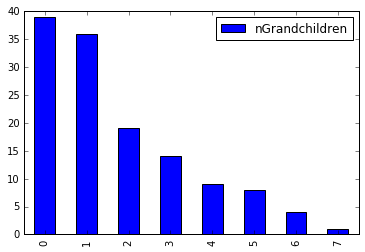

In [10]:
print ets
ets.plot(kind='bar')

# ets['nGrandchildren']

In [11]:
ets

,child,nGrandchildren
0,http://schema.org/CreativeWork,39
1,http://schema.org/Intangible,36
2,http://schema.org/Event,19
3,http://schema.org/Action,14
4,http://schema.org/Organization,9
5,http://schema.org/Place,8
6,http://schema.org/Product,4
7,http://schema.org/Person,1


# Property counts e.g. Movie
<a id="moviecount"></a>


In [68]:
# Properties on each class (outgoing)

# What's wrong with this query?
#s = "SELECT distinct ?t (count(?prop) as ?n)  WHERE { ?prop schema:domainIncludes ?t . } GROUP BY ?prop ORDER BY DESC(?n)"


s = """SELECT ?t (count(?prop) as ?n)  WHERE { ?prop schema:domainIncludes ?t . 
FILTER (?t = <http://schema.org/Movie> ) . } GROUP BY ?t ORDER BY DESC(?n)"""
sparql2df(  sdocore.query( s))

# Something is wrong here. Movie should have 10 properties (2 of which are superseded: actors, directors).
# Why are there multiple rows?


,t,n
0,http://schema.org/Movie,10


In [13]:
# Properties on each class (*incoming*)
s = "SELECT  ?t (count(?prop) as ?n)  WHERE { ?prop schema:rangeIncludes ?t . } GROUP BY ?prop ORDER BY DESC(?n)"
sparql2df(  sdocore.query( s))


,t,n
0,http://schema.org/StructuredValue,5
1,http://schema.org/Number,4
2,http://schema.org/AdministrativeArea,4
3,http://schema.org/ContactPoint,4
4,http://schema.org/URL,3
5,http://schema.org/Thing,3
6,http://schema.org/PriceSpecification,3
7,http://schema.org/Boolean,3
8,http://schema.org/Place,3
9,http://schema.org/QualitativeValue,3


In [14]:
sparql2df( sdocore.query("select ?x where { ?x rdfs:subClassOf <http://schema.org/Event> } LIMIT 30 ") )


,x
0,http://schema.org/Festival
1,http://schema.org/DanceEvent
2,http://schema.org/BusinessEvent
3,http://schema.org/SocialEvent
4,http://schema.org/ExhibitionEvent
5,http://schema.org/PublicationEvent
6,http://schema.org/DeliveryEvent
7,http://schema.org/EducationEvent
8,http://schema.org/ComedyEvent
9,http://schema.org/MusicEvent


In [15]:
sdocore

<Graph identifier=http://schema.org/ (<class 'rdflib.graph.Graph'>)>

In [16]:
s = "select ?x where { ?x rdfs:subClassOf <http://schema.org/CreativeWork> } LIMIT 60 "
a = sdocore.query(s)
sparql2df( a )

,x
0,http://schema.org/Blog
1,http://schema.org/TVSeries
2,http://schema.org/SoftwareSourceCode
3,http://schema.org/PublicationVolume
4,http://schema.org/Episode
5,http://schema.org/Clip
6,http://schema.org/DataCatalog
7,http://schema.org/Sculpture
8,http://schema.org/Review
9,http://schema.org/CreativeWorkSeries


In [ ]:
# Unit Tests
# Seems we could run them here, https://amodernstory.com/2015/06/28/running-unittests-in-the-ipython-notebook/
# unittest.TextTestRunner().run(suite)

In [55]:
s="""
PREFIX schema: <http://schema.org/> 
SELECT distinct ?t (count(?prop) as ?n) 
WHERE { 
?prop schema:domainIncludes ?t . FILTER (?t = <http://schema.org/Movie> ) .
} 
GROUP BY ?prop ORDER BY DESC(?n)"""

sparql2df( sdocore.query(s) )

,t,n
0,http://schema.org/Movie,1


# Debugging. 
<a id="debugcounts"></a>

Something is wrong with the count queries above. 

* The count query thinks 11 property terms apply directly to Movie
* Querying finds just 10
* http://staging.schema.org/Movie shows just 8, because 'actors' and 'directors' were suppressed. By why 11 not 10?
* Trying in Dydra, see http://dydra.com/danbri/schema-org-3-1-sdo-makemake/@query#counting-props-on-types


In [29]:
s = "SELECT distinct ?t (count(?prop) as ?n)  WHERE { ?prop schema:domainIncludes ?t . } GROUP BY ?prop ORDER BY DESC(?n) LIMIT 5"
sparql2df(  sdocore.query( s))


,t,n
0,http://schema.org/Movie,11
1,http://schema.org/VideoGameSeries,11
2,http://schema.org/ReturnAction,9
3,http://schema.org/RadioSeries,9
4,http://schema.org/MovieSeries,9


In [27]:
s = "SELECT distinct *  WHERE { ?prop schema:domainIncludes <http://schema.org/Movie> . }"
sparql2df(  sdocore.query( s))


,prop
0,http://schema.org/actors
1,http://schema.org/musicBy
2,http://schema.org/actor
3,http://schema.org/subtitleLanguage
4,http://schema.org/trailer
5,http://schema.org/directors
6,http://schema.org/duration
7,http://schema.org/productionCompany
8,http://schema.org/director
9,http://schema.org/countryOfOrigin


#  debugging counts
<a id="debug_counts2"></a>


In [41]:
s = """SELECT distinct ?t (count(?prop) as ?n) ?prop2
WHERE { 
OPTIONAL { ?prop schema:domainIncludes ?t . }  
?prop2 schema:supersededBy ?prop .
FILTER (?t = <http://schema.org/Movie>) .
} 
GROUP BY ?prop ORDER BY DESC(?n)
"""
# sparql2df(  sdocore.query( s))


s = """SELECT distinct *  WHERE  {
 ?prop schema:domainIncludes <http://schema.org/Movie> . 
 ?prop2 schema:supersededBy ?prop . 
}"""
sparql2df(  sdocore.query( s))




,prop,prop2
0,http://schema.org/actor,http://schema.org/actors
1,http://schema.org/director,http://schema.org/directors
